In [416]:
import re
import os
import json
import spacy
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from groq import Groq
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

In [303]:
df = pd.read_csv("label.csv", sep=";")
df.columns = df.columns.str.lower()
df

,username,comment,sentimen
0,kak_ntank,Terima kasih,positif
1,watun_syana,Alhamdulillah bapak bupati sangat peduli denga...,positif
2,mas_iril_namine,tetep semangat pak bupati,positif
3,st.budi27,semangat gus🔥🔥🔥,positif
4,armansaleh432,Semoga pemkab gresik dan pemerintah pusat khus...,positif
...,...,...,...
853,yonno_utomo,Aamiin,positif
854,citra.handayani.saja,Gresik itu kompak dalam menghadapi apapun . Te...,positif
855,cindy_tamaraaa,menyala guss🔥,positif
856,abde_prastio,sinergi luar biasa 👏,positif


In [304]:
def case_folding(text):
    return text.lower()

df["case_folding"] = df["comment"].apply(case_folding)
df

,username,comment,sentimen,case_folding
0,kak_ntank,Terima kasih,positif,terima kasih
1,watun_syana,Alhamdulillah bapak bupati sangat peduli denga...,positif,alhamdulillah bapak bupati sangat peduli denga...
2,mas_iril_namine,tetep semangat pak bupati,positif,tetep semangat pak bupati
3,st.budi27,semangat gus🔥🔥🔥,positif,semangat gus🔥🔥🔥
4,armansaleh432,Semoga pemkab gresik dan pemerintah pusat khus...,positif,semoga pemkab gresik dan pemerintah pusat khus...
...,...,...,...,...
853,yonno_utomo,Aamiin,positif,aamiin
854,citra.handayani.saja,Gresik itu kompak dalam menghadapi apapun . Te...,positif,gresik itu kompak dalam menghadapi apapun . te...
855,cindy_tamaraaa,menyala guss🔥,positif,menyala guss🔥
856,abde_prastio,sinergi luar biasa 👏,positif,sinergi luar biasa 👏


In [305]:
def cleaning(text):
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)
    text = re.sub(r"#[A-Za-z0-9]+", " ", text)
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[0-9]+", " ", text)
    text = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", text)
    text = text.strip()
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    return text

df["cleaning"] = df["case_folding"].apply(cleaning)
df = df[df["cleaning"] != ""].reset_index(drop=True)
df

,username,comment,sentimen,case_folding,cleaning
0,kak_ntank,Terima kasih,positif,terima kasih,terima kasih
1,watun_syana,Alhamdulillah bapak bupati sangat peduli denga...,positif,alhamdulillah bapak bupati sangat peduli denga...,alhamdulillah bapak bupati sangat peduli denga...
2,mas_iril_namine,tetep semangat pak bupati,positif,tetep semangat pak bupati,tetep semangat pak bupati
3,st.budi27,semangat gus🔥🔥🔥,positif,semangat gus🔥🔥🔥,semangat gus
4,armansaleh432,Semoga pemkab gresik dan pemerintah pusat khus...,positif,semoga pemkab gresik dan pemerintah pusat khus...,semoga pemkab gresik dan pemerintah pusat khus...
...,...,...,...,...,...
842,yonno_utomo,Aamiin,positif,aamiin,aamiin
843,citra.handayani.saja,Gresik itu kompak dalam menghadapi apapun . Te...,positif,gresik itu kompak dalam menghadapi apapun . te...,gresik itu kompak dalam menghadapi apapun teta...
844,cindy_tamaraaa,menyala guss🔥,positif,menyala guss🔥,menyala guss
845,abde_prastio,sinergi luar biasa 👏,positif,sinergi luar biasa 👏,sinergi luar biasa


In [306]:
load_dotenv(".env")
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

def translate(text_list):
    translated_text = ""
    success = False

    while not success:
        try:
            completion = client.chat.completions.create(
                model="llama3-70b-8192",
                messages=[
                    {
                        "role": "user",
                        "content": f"You are an expert translator. Translate the following sentence {text_list} from Indonesian to formal English. Just return the translated sentence without any explanation or additional text. IMPORTANT: No explanation or additional text besides the translated sentence itself!!!"
                    }
                ],
                temperature=1,
                max_tokens=10_000,
                top_p=1,
                stream=True,
                stop=None,
            )

            for chunk in completion:
                translated_text += chunk.choices[0].delta.content or ""
            
            success = True
        except Exception as e:
            print(f"Error: {e}. Retrying...")

    return translated_text

In [307]:
def translate_in_batches(df, column_name, batch_size=10):
    all_translated_texts = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch = list(df[column_name][i:i + batch_size])
        translated_batch = [translate(text) for text in batch]
        all_translated_texts.extend(translated_batch)

    return all_translated_texts

In [257]:
all_translated_texts = translate_in_batches(df, "cleaning", batch_size=10)

 56%|█████▋    | 48/85 [29:56<17:43, 28.74s/it]   

Error: The read operation timed out. Retrying...


100%|██████████| 85/85 [47:41<00:00, 33.67s/it]


In [263]:
len(df) == len(all_translated_texts)

True

In [268]:
with open("all_translated_texts.json", "w", encoding="utf-8") as f:
    json.dump(all_translated_texts, f, ensure_ascii=False, indent=4)

In [308]:
def clean_string(s):
    s = s.strip()

    if (s.startswith('"') and s.endswith('"')) or (s.startswith("'") and s.endswith("'")):
        s = s[1:-1]

    if s.startswith("'") and s.endswith("'"):
        s = s[1:-1].replace('"', '')

    elif s.startswith('"') and s.endswith('"'):
        s = s[1:-1].replace("'", '')

    return s

def clean_list(lst):
    return [clean_string(s) for s in lst]

with open("all_translated_texts.json", "r", encoding="utf-8") as f:
    all_translated_texts = json.load(f)

all_translated_texts = clean_list(all_translated_texts)

In [309]:
df["translated_comment"] = all_translated_texts
df = df[["username", "sentimen", "comment", "translated_comment"]]
df

,username,sentimen,comment,translated_comment
0,kak_ntank,positif,Terima kasih,Thank you.
1,watun_syana,positif,Alhamdulillah bapak bupati sangat peduli denga...,"Praise be to God, the regent's father is very ..."
2,mas_iril_namine,positif,tetep semangat pak bupati,"Keep the spirit up, Mr. Regent!"
3,st.budi27,positif,semangat gus🔥🔥🔥,"The spirit, dude!"
4,armansaleh432,positif,Semoga pemkab gresik dan pemerintah pusat khus...,May the Gresik Regency Government and the Cent...
...,...,...,...,...
842,yonno_utomo,positif,Aamiin,Amen.
843,citra.handayani.saja,positif,Gresik itu kompak dalam menghadapi apapun . Te...,"Gresik is compact in facing anything, the spir..."
844,cindy_tamaraaa,positif,menyala guss🔥,It's lit!
845,abde_prastio,positif,sinergi luar biasa 👏,Exceptional synergy.


In [310]:
for index, (value_1, value_2) in enumerate(zip(df["comment"], df["translated_comment"])):
    print(f"Row {index}")
    print(f"Indonesian\t: {value_1}")
    print(f"English\t\t: {value_2}")
    print("")

Row 0
Indonesian	: Terima kasih
English		: Thank you.

Row 1
Indonesian	: Alhamdulillah bapak bupati sangat peduli dengan warga di pulau Bawean
English		: Praise be to God, the regent's father is very concerned about the islanders of Bawean.

Row 2
Indonesian	: tetep semangat pak bupati
English		: Keep the spirit up, Mr. Regent!

Row 3
Indonesian	: semangat gus🔥🔥🔥
English		: The spirit, dude!

Row 4
Indonesian	: Semoga pemkab gresik dan pemerintah pusat khususnya memberi panduan untuk bangun rumah atau bangunan tahan gempa
English		: May the Gresik Regency Government and the Central Government, especially, provide guidance for building earthquake-resistant houses or buildings.

Row 5
Indonesian	: Tetap semangat selalu Gus kuu
English		: Always keep the spirit, bro!

Row 6
Indonesian	: Min, mohon logistik dipercepat
English		: We kindly request that logistics be expedited.

Row 7
Indonesian	: Bawean butuh bantuan min, mohon dipercepat logistik🙏
English		: Bawean needs assistance, please

In [313]:
def case_folding(text):
    return text.lower()

df.loc[:, "case_folding"] = df["translated_comment"].apply(case_folding)
df

,username,sentimen,comment,translated_comment,case_folding
0,kak_ntank,positif,Terima kasih,Thank you.,thank you.
1,watun_syana,positif,Alhamdulillah bapak bupati sangat peduli denga...,"Praise be to God, the regent's father is very ...","praise be to god, the regent's father is very ..."
2,mas_iril_namine,positif,tetep semangat pak bupati,"Keep the spirit up, Mr. Regent!","keep the spirit up, mr. regent!"
3,st.budi27,positif,semangat gus🔥🔥🔥,"The spirit, dude!","the spirit, dude!"
4,armansaleh432,positif,Semoga pemkab gresik dan pemerintah pusat khus...,May the Gresik Regency Government and the Cent...,may the gresik regency government and the cent...
...,...,...,...,...,...
842,yonno_utomo,positif,Aamiin,Amen.,amen.
843,citra.handayani.saja,positif,Gresik itu kompak dalam menghadapi apapun . Te...,"Gresik is compact in facing anything, the spir...","gresik is compact in facing anything, the spir..."
844,cindy_tamaraaa,positif,menyala guss🔥,It's lit!,it's lit!
845,abde_prastio,positif,sinergi luar biasa 👏,Exceptional synergy.,exceptional synergy.


In [314]:
def cleaning(text):
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)
    text = re.sub(r"#[A-Za-z0-9]+", " ", text)
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[0-9]+", " ", text)
    text = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", text)
    text = text.strip()
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    return text

df.loc[:, "cleaning"] = df["case_folding"].apply(cleaning)
df = df[df["cleaning"] != ""].reset_index(drop=True)
df

,username,sentimen,comment,translated_comment,case_folding,cleaning
0,kak_ntank,positif,Terima kasih,Thank you.,thank you.,thank you
1,watun_syana,positif,Alhamdulillah bapak bupati sangat peduli denga...,"Praise be to God, the regent's father is very ...","praise be to god, the regent's father is very ...",praise be to god the regent s father is very ...
2,mas_iril_namine,positif,tetep semangat pak bupati,"Keep the spirit up, Mr. Regent!","keep the spirit up, mr. regent!",keep the spirit up mr regent
3,st.budi27,positif,semangat gus🔥🔥🔥,"The spirit, dude!","the spirit, dude!",the spirit dude
4,armansaleh432,positif,Semoga pemkab gresik dan pemerintah pusat khus...,May the Gresik Regency Government and the Cent...,may the gresik regency government and the cent...,may the gresik regency government and the cent...
...,...,...,...,...,...,...
842,yonno_utomo,positif,Aamiin,Amen.,amen.,amen
843,citra.handayani.saja,positif,Gresik itu kompak dalam menghadapi apapun . Te...,"Gresik is compact in facing anything, the spir...","gresik is compact in facing anything, the spir...",gresik is compact in facing anything the spir...
844,cindy_tamaraaa,positif,menyala guss🔥,It's lit!,it's lit!,it s lit
845,abde_prastio,positif,sinergi luar biasa 👏,Exceptional synergy.,exceptional synergy.,exceptional synergy


In [316]:
def lemmatization(text, allowed_postags=["NOUN", "ADJ", "VERB", "ADV", "PROPN"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    doc = nlp(text)
    new_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return " ".join(new_text)

df.loc[:, "lemmatization"] = df["cleaning"].apply(lemmatization)
df.head()

,username,sentimen,comment,translated_comment,case_folding,cleaning,lemmatization
0,kak_ntank,positif,Terima kasih,Thank you.,thank you.,thank you,thank
1,watun_syana,positif,Alhamdulillah bapak bupati sangat peduli denga...,"Praise be to God, the regent's father is very ...","praise be to god, the regent's father is very ...",praise be to god the regent s father is very ...,praise god regent s father very concerned isla...
2,mas_iril_namine,positif,tetep semangat pak bupati,"Keep the spirit up, Mr. Regent!","keep the spirit up, mr. regent!",keep the spirit up mr regent,keep spirit mr regent
3,st.budi27,positif,semangat gus🔥🔥🔥,"The spirit, dude!","the spirit, dude!",the spirit dude,spirit dude
4,armansaleh432,positif,Semoga pemkab gresik dan pemerintah pusat khus...,May the Gresik Regency Government and the Cent...,may the gresik regency government and the cent...,may the gresik regency government and the cent...,gresik regency government central government e...


In [318]:
def remove_stopwords(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    new_text = [token.text for token in doc if not token.is_stop]
    return " ".join(new_text)

df.loc[:, "remove_stopwords"] = df["lemmatization"].apply(remove_stopwords)
df.head()

,username,sentimen,comment,translated_comment,case_folding,cleaning,lemmatization,remove_stopwords
0,kak_ntank,positif,Terima kasih,Thank you.,thank you.,thank you,thank,thank
1,watun_syana,positif,Alhamdulillah bapak bupati sangat peduli denga...,"Praise be to God, the regent's father is very ...","praise be to god, the regent's father is very ...",praise be to god the regent s father is very ...,praise god regent s father very concerned isla...,praise god regent s father concerned islander ...
2,mas_iril_namine,positif,tetep semangat pak bupati,"Keep the spirit up, Mr. Regent!","keep the spirit up, mr. regent!",keep the spirit up mr regent,keep spirit mr regent,spirit mr regent
3,st.budi27,positif,semangat gus🔥🔥🔥,"The spirit, dude!","the spirit, dude!",the spirit dude,spirit dude,spirit dude
4,armansaleh432,positif,Semoga pemkab gresik dan pemerintah pusat khus...,May the Gresik Regency Government and the Cent...,may the gresik regency government and the cent...,may the gresik regency government and the cent...,gresik regency government central government e...,gresik regency government central government e...


In [397]:
X = df["remove_stopwords"]
y = df["sentimen"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [417]:
text_clf_lsvc = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("smoteenn", SMOTEENN(random_state=42)),
    ("clf", SVC(kernel="linear", class_weight="balanced", random_state=42)),
])

In [418]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear',
                     random_state=42))])

In [419]:
predictions = text_clf_lsvc.predict(X_test)

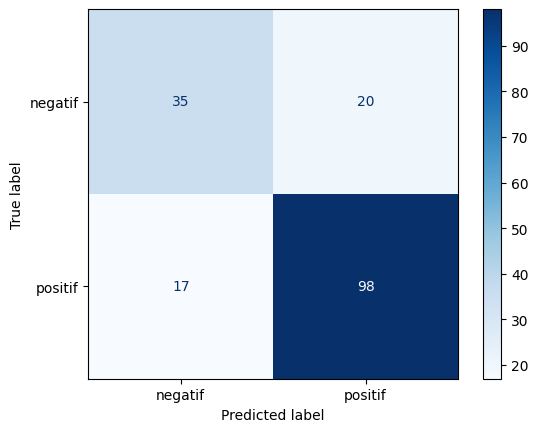

In [420]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=text_clf_lsvc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [421]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

     negatif       0.67      0.64      0.65        55
     positif       0.83      0.85      0.84       115

    accuracy                           0.78       170
   macro avg       0.75      0.74      0.75       170
weighted avg       0.78      0.78      0.78       170



In [422]:
accuracy_score(y_test, predictions)

0.7823529411764706